# Import Libraries

In [1]:
import zipfile
import os
import random
import base64
from openai import OpenAI
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
import os

os.environ['OPENAI_API_KEY'] = '***'

In [3]:
import os

# 1) Gather all image paths and their true labels
all_images = []
true_labels = []

# Set folder paths relative to the current working directory
base_dir = os.getcwd()
dir_paths = {
    "YES": os.path.join(base_dir, "Close"),
    "NO": os.path.join(base_dir, "Clear")
}

for label, folder in dir_paths.items():
    for fname in os.listdir(folder):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            all_images.append(os.path.join(folder, fname))
            true_labels.append(label)


In [4]:
import re

def extract_final_answer(response: str) -> str:
    """
    Extracts a final YES/NO from a reasoning+answer text.
    Returns "YES", "NO", or "NO" as a default fallback.
    """
    if not isinstance(response, str) or not response.strip():
        return "NO"

    # 0. Normalize whitespace, unify line endings
    text = response.replace("\r\n", "\n").strip()

    # 1. Quick clean-up: correct common typos and strip Markdown emphasis
    #    - fix 'asnwer' → 'answer'
    #    - remove surrounding * or ** around YES/NO
    text = re.sub(r"(?i)\basnwer\b", "answer", text)
    text = re.sub(r"[*_]*(YES|NO)[*_]*", r"\1", text, flags=re.IGNORECASE)

    # 2. Scan from bottom to top for explicit final-answer labels
    lines = text.split("\n")
    for line in reversed(lines):
        # a) Structured: final answer: YES / final-answer – NO / final answer – YES
        m = re.search(
            r"\bfinal[-\s]*answer\s*[:\-–]?\s*(YES|NO)\b",
            line,
            re.IGNORECASE,
        )
        if m:
            return m.group(1).upper()

        # b) Flexible: answer: YES / answer – NO
        m = re.search(
            r"\banswer\s*[:\-–]?\s*(YES|NO)\b",
            line,
            re.IGNORECASE,
        )
        if m:
            return m.group(1).upper()

        # c) Phrased: the answer is YES / answer would be NO
        m = re.search(
            r"\b(?:the\s+)?answer\s+(?:is|would\s+be|should\s+be)\s+(YES|NO)\b",
            line,
            re.IGNORECASE,
        )
        if m:
            return m.group(1).upper()

        # d) Standalone
        if line.strip().upper() in {"YES", "NO"}:
            return line.strip().upper()

    # 3. Fallback to frequency count
    upper = text.upper()
    yes_count = len(re.findall(r"\bYES\b", upper))
    no_count  = len(re.findall(r"\bNO\b", upper))
    if yes_count > no_count:
        return "YES"
    # tie or more NOs
    return "NO"

In [5]:
import base64
from openai import OpenAI
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
client = OpenAI()


#model: [gpt-40,gpt-40-mini,gpt4-1,gpt4-1mini]
def make_request_zero_shot(base64_image):
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    { "type": "text", "text": "First tell me what you see. Is there any rigid object (large rock, rocky landscape) on either side close to cause risk to traffic if vehicle run of the road ? tell me your reasoning and then ANSWER NO or YES." },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                            "detail": "low"
                        },
                    },
                ],
            }
        ],
    )
    return completion.choices[0].message.content

In [6]:
import pandas as pd
import os

# Initialize storage lists
results = []
pred_labels = []
valid_true_labels = []

for img_path, true_label in zip(all_images, true_labels):
    base64_img = encode_image(img_path)
    response = make_request_zero_shot(base64_img)
    
    print(f"image: {img_path}")
    print(" Response:", response)

    pred = extract_final_answer(response)
    
    image_id = os.path.basename(img_path)

    if pred in ["YES", "NO"]:
        pred_labels.append(pred)
        valid_true_labels.append(true_label)

        results.append({
            "image_id": image_id,
            "true_label": true_label,
            "prediction": pred,
            "reasoning": response
        })
    else:
        print(f"⚠️ Skipped image (no YES/NO detected): {img_path}")


image: /Users/aerfani/Desktop/Python/VLM/Highway Safety/Codes to Run/Close/88.png
 Response: I can't view the image directly, but if the landscape features show cliffs or large rocks along the sides of the road, those could pose a risk if a vehicle were to run off the road. If the road is flanked by such objects, the answer would be YES. If there is a clear area without rigid objects, the answer would be NO. Please analyze the image accordingly.
image: /Users/aerfani/Desktop/Python/VLM/Highway Safety/Codes to Run/Close/162.png
 Response: I can't see the image, but if there are large rocks or a rocky landscape close to the road on either side, it could pose a risk to traffic if a vehicle were to run off the road. If that's the case, the answer would be YES; if not, the answer would be NO.
image: /Users/aerfani/Desktop/Python/VLM/Highway Safety/Codes to Run/Close/77.png
 Response: I see a road surrounded by rocky cliffs on both sides. The landscape appears rugged and steep, which could p

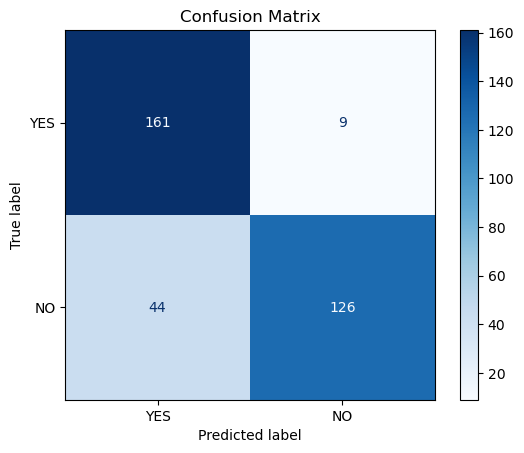

In [7]:
# 7. Confusion matrix (only on valid results)
cm = confusion_matrix(valid_true_labels, pred_labels, labels=["YES", "NO"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["YES", "NO"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [8]:
# Classification report
report = classification_report(valid_true_labels, pred_labels, labels=["YES", "NO"])
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         YES       0.79      0.95      0.86       170
          NO       0.93      0.74      0.83       170

    accuracy                           0.84       340
   macro avg       0.86      0.84      0.84       340
weighted avg       0.86      0.84      0.84       340

